In [1]:
!nvidia-smi

Fri Nov 21 22:15:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:19:00.0 Off |                   On |
| N/A   50C    P0            174W /  300W |   11590MiB /  81920MiB |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

### Load Modules

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import pyvista as pv
import matplotlib.pyplot as p
import pyvista as pv
from matplotlib.colors import LinearSegmentedColormap,ListedColormap, BoundaryNorm
import cedalion.dataclasses as cdc
import scipy.signal
import cedalion.sigproc.motion_correct as motion_correct
pv.set_jupyter_backend("html")
from cedalion import units
from cedalion.vis import plot_sensitivity_matrix
import cedalion
import cedalion.sigproc.quality as quality
import cedalion.sigproc.physio as physio
import cedalion.nirs as nirs
import cedalion.plots as plots
from cedalion.io.probe_geometry import load_tsv
import cedalion.geometry.landmarks
from cedalion.imagereco.solver import pseudo_inverse_stacked
from cedalion.io.forward_model import load_Adot,save_Adot
import cedalion.imagereco.forward_model as fwm
from cedalion.imagereco.forward_model import apply_inv_sensitivity, TwoSurfaceHeadModel, stack_flat_channel
from cedalion.datasets import get_icbm152_segmentation
import pickle
from typing import Tuple
from pint import Quantity
import glob 
import re
from pathlib import Path
from cedalion.io import read_events_from_tsv
from pathlib import PureWindowsPath
from cedalion.io import read_snirf


%load_ext autoreload
%autoreload 2
%matplotlib widget


In [3]:
def od2parcel(od , B):
        
    dC_brain, dC_scalp = apply_inv_sensitivity(od, B)

    dC_brain = dC_brain.pint.quantify().pint.to("uM").pint.dequantify()
    dC_scalp = dC_scalp.pint.quantify().pint.to("uM").pint.dequantify()


    # alternatively use 1/conc_var to weight vertex sensitivity and then normalize by sum of weights
    hbr = dC_brain.sel(chromo='HbR').groupby('parcel').mean()
    hbo = dC_brain.sel(chromo='HbO').groupby('parcel').mean()
    signal_raw = xr.concat([hbo, hbr], dim='chromo')

    # revised matrix
    signal_raw = signal_raw.sel(parcel=signal_raw.parcel != 'Background+FreeSurfer_Defined_Medial_Wall_LH')
    signal_raw = signal_raw.sel(parcel=signal_raw.parcel != 'Background+FreeSurfer_Defined_Medial_Wall_RH')
    
    return signal_raw

def plot_sens_parcels(removed_parcels, head, subject):
    b = cdc.VTKSurface.from_trimeshsurface(head.brain)
    b = pv.wrap(b.mesh)

    PARCEL_DIR = cedalion.datasets.get_icbm152_parcel_file()
    parcels_file = cedalion.io.read_parcellations(PARCEL_DIR)

    plt = pv.Plotter()

    # Find mask of rows to update
    mask = parcels_file["Label"].isin(removed_parcels)
    # Use .loc with .apply to set the Color column per row
    parcels_plotsens = parcels_file.copy()
    parcels_plotsens.loc[mask, "Color"] = parcels_plotsens.loc[mask, "Color"].apply(lambda _: [1, 1, 1])

    b = cdc.VTKSurface.from_trimeshsurface(head.brain)
    b = pv.wrap(b.mesh)
    b["parcels"] = parcels_plotsens.Color.tolist()
    plt.add_text('#parcels: {}'.format(604-len(removed_parcels)), font_size=8)

    plt.add_mesh(
        b,
        scalars="parcels",
        rgb=True
    )

    cog = head.brain.vertices.mean("label").values
    plt.camera.position = cog + [0,0,400]
    plt.camera.focal_point = cog
    plt.camera.up = [0,1,0] 
    plt.reset_camera()
    
    plt.save_graphic('{}sub-{}.svg'.format(SAVE, subject))
    
    return

def get_cmeas(od_data: xr.DataArray, list_bad_ch: list,get_diag: bool=True, bad_rel_var: float = 1e6,dw_bad_ch : bool = True):
    od_stacked = stack_flat_channel(od_data)

    bad_ch_wv = [(760.0, channel) for channel in list_bad_ch] + [(850.0, channel) for channel in list_bad_ch]
    
    flat_channel_index = od_stacked.indexes['flat_channel']
    indices_bad_channels = [flat_channel_index.get_loc(ch_tuple) for ch_tuple in bad_ch_wv]
    # indices_bad_channels

    od_stacked = od_stacked.drop_indexes(["flat_channel", "wavelength", "channel"])
    # xr.cov(od_stacked.rename({"flat_channel" : "flat_channel1"}), od_stacked.rename({"flat_channel" : "flat_channel2"}), dim="time")
    c_meas=np.cov(od_stacked.T)
    
    if get_diag == True:
        c_meas=np.diag(np.diag(c_meas))
    else:
        pass

    if dw_bad_ch == True:
        for idx in indices_bad_channels:
            c_meas[idx, idx] = c_meas[idx, idx] * bad_rel_var
    else:
        pass
    
    return c_meas

def get_bad_ch_mask(int_data: xr.DataArray,  ch_preproc: dict):
    
    # SCI and PSP Mask    
    sci, sci_mask = quality.sci(int_data, ch_preproc['window_len'], ch_preproc['sci_thresh'])
    psp, psp_mask = quality.psp(int_data, ch_preproc['window_len'], ch_preproc['psp_thresh'])

    # Saturated and Dark Channels
    amp_threshs_sat = [0., ch_preproc['dark_sat_thresh'][1]]
    amp_threshs_low = [ch_preproc['dark_sat_thresh'][0], 1]
    amp_sat, amp_mask_sat = quality.mean_amp(int_data, amp_threshs_sat)
    amp_low, amp_mask_low = quality.mean_amp(int_data, amp_threshs_low)

    amp_mask=amp_mask_sat & amp_mask_low
    sci_psp_mask=sci_mask & psp_mask
    perc_time_clean = sci_psp_mask.sum(dim="time") / len(sci.time)

    scipsp_bad_ch=[]
    for ch in perc_time_clean.channel.values:
        if perc_time_clean.sel(channel=ch).values < ch_preproc['perc_time_clean']: # dont make the mistake of using the inv condition >:| 
            scipsp_bad_ch.append(ch)

    amp_bad_ch=[]
    for ch in amp_mask.channel.values:
        if amp_mask.sel(channel=ch,wavelength='760').values == False or amp_mask.sel(channel=ch,wavelength='850').values == False:
            amp_bad_ch.append(ch)

    sum_bad_ch = amp_bad_ch + scipsp_bad_ch
    list_bad_ch = sorted(list(set(sum_bad_ch)))  # remove duplicates

    print("Flagged Channels : ",len(list_bad_ch), '/', len(int_data.channel))
    print("Percentage: ", int(len(list_bad_ch) / len(int_data.channel) * 100), '%')
    
    return list_bad_ch

In [4]:
def standardize_trial_types(DATASET_NAME: str, file: str, stim: pd.DataFrame, rec):
    
    if DATASET_NAME == "FreshMotor":
        # map trial types to left or right depending on the name of the file
        m = re.search(r'(?i)(left|right)', file)

        # rename from MOTOR to left/right
        stim.trial_type = m.group(1).lower()
        rec.stim = stim
    
    else:
        mapping = {
            "Right": "right", # BallSqueezingHD
            "Left": "left",   # BallSqueezingHD
            "ElectricalVAS7": "right", # TODO: Electrical_Thermal
            "ElectricalVAS3": "left",  # TODO: Electrical_Thermal
        }
        stim["trial_type"] = stim["trial_type"].replace(mapping)


    # attach/update stim info to rec
    rec.stim = stim

    return stim, rec

In [5]:
def match_landmark_labels(rec):
    subject_nasion_mask = rec.geo3d['label'].data == 'NASION'

    new_labels = rec.geo3d['label'].data.copy()
    new_labels[subject_nasion_mask] = 'Nz'

    # Create new geo3d with updated labels
    rec.geo3d = rec.geo3d.assign_coords(label=new_labels)
    # print(rec.geo3d['label'].data)

    return rec

# Load dataset

In [ ]:
# Available datasets:
DATASET_NAME = "BallSqueezingHD_modified"
# DATASET_NAME = "BS_Laura"
# DATASET_NAME = "FreshMotor"
# DATASET_NAME = "ElectricalThermal"

base_path = '/home/orabe/sparse_to_dense_fnirs'

if DATASET_NAME == "BallSqueezingHD_modified":
    dataset_path = f"{base_path}/datasets/raw/{DATASET_NAME}/sub-*/nirs/sub-*.snirf"

elif DATASET_NAME == "BS_Laura":
    dataset_path = f"{base_path}/datasets/raw/{DATASET_NAME}/sub-*/nirs/sub-*.snirf"
    
elif DATASET_NAME == "Electrical_Thermal":
    dataset_path = f"{base_path}/datasets/raw/{DATASET_NAME}/sub-*/ses-*/nirs/sub-*_ses-*_task-Electrical*_nirs.snirf"
    # TODO: exclude subjects without txt files for landmarks coords
    
elif DATASET_NAME == "FreshMotor":
    duration = "*" # * to include both 2s and 3s
    dataset_path = f"{base_path}/datasets/raw/{DATASET_NAME}/sub-*/ses-*{duration}/nirs/sub-*_ses-*{duration}_task-FRESHMOTOR_nirs.snirf"
else:
    raise ValueError("Unknown dataset name")

files = glob.glob(dataset_path)

# TODO: to be confirmed
# remove non-BS files for Laura's dataset to avoid errors
if DATASET_NAME == "BS_Laura":
    files = [p for p in files if "BS" in os.path.basename(p)]
    
files = sorted(files)
print(f"{len(files)} files found.")
files


40 files found.


['/home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-01/ses-left2s/nirs/sub-01_ses-left2s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-01/ses-left3s/nirs/sub-01_ses-left3s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-01/ses-right2s/nirs/sub-01_ses-right2s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-01/ses-right3s/nirs/sub-01_ses-right3s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-02/ses-left2s/nirs/sub-02_ses-left2s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-02/ses-left3s/nirs/sub-02_ses-left3s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-02/ses-right2s/nirs/sub-02_ses-right2s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-02/ses-right3s/nirs/

# Inspecting data

## Load Rec data from first file

In [7]:
# load first file for 
print(files[0])
rec = cedalion.io.read_snirf(files[0])[0] 
rec.stim.head(20)

/home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-01/ses-left2s/nirs/sub-01_ses-left2s_task-FRESHMOTOR_nirs.snirf


,onset,duration,value,trial_type
0,61.040003,2.0,1.0,motor
1,78.176004,2.0,1.0,motor
2,99.232005,2.0,1.0,motor
3,117.488006,2.0,1.0,motor
4,138.656007,2.0,1.0,motor
5,156.800008,2.0,1.0,motor
6,172.032008,2.0,1.0,motor
7,188.384009,2.0,1.0,motor
8,203.392010,2.0,1.0,motor
9,226.464011,2.0,1.0,motor


In [8]:
print(rec.stim.groupby("trial_type")[["onset"]].count())

            onset
trial_type       
motor          25


### Check stim onsets (onsets are in seconds)

In [9]:
print(np.diff(np.sort(rec.stim.onset.values)))
print(np.min(np.diff(np.sort(rec.stim.onset.values))))

[17.136001 21.056001 18.256001 21.168001 18.144001 15.232    16.352001
 15.008001 23.072001 19.376001 17.024001 13.664    14.672001 21.168001
 14.224001 22.064001 14.224    17.136001 19.264001 18.144001 20.048001
 22.176001 18.144001 19.264001]
13.663999999999987


### Check wavelength values

In [10]:
print(rec.timeseries['amp'].wavelength.values)

[760. 850.]


### Verify sampling rate

In [ ]:
time = rec.timeseries['amp'].time.data
dt = np.diff(time)
fs_mean = 1.0 / np.mean(dt)
fs_median = 1.0 / np.median(dt)

print(f"fs (mean)   = {fs_mean:.3f} Hz")
print(f"fs (median) = {fs_median:.3f} Hz")

print(f"dt mean     = {np.mean(dt):.6f} s")
print(f"dt median   = {np.median(dt):.6f} s")
print(f"dt std      = {np.std(dt):.6f} s")
print(f"dt min      = {np.min(dt):.6f} s")
print(f"dt max      = {np.max(dt):.6f} s")

fs (mean)   = 8.929 Hz
fs (median) = 8.929 Hz
dt mean     = 0.112000 s
dt median   = 0.112000 s
dt std      = 0.000000 s
dt min      = 0.112000 s
dt max      = 0.112000 s


In [12]:
 # manually copy fs from json files
if DATASET_NAME == "BallSqueezingHD_modified":
    fs = 8.719308035714286
elif DATASET_NAME == "BS_Laura":
    fs = 8.98876404494382
elif DATASET_NAME == "Electrical_Thermal":
    fs = 50.0 # TODO: downsample
elif DATASET_NAME == "FreshMotor":
    fs = 8.928571428571429

# Overwrite fs
fs = 9.0  # rounded value for all datasets

### verify landmarks. This will be matched below

In [13]:
geo3d = rec.geo3d
# all(label in geo3d.label.data for label in ["Nz", "Iz", "LPA", "RPA", "Cz"])
for landmark_label in ["Nz", "Iz", "LPA", "RPA", "Cz", "NASION"]:
    print(f"- {landmark_label}: {landmark_label in geo3d.label.data}")
    
# print all labels next to each other
print("Optode labels:", ", ".join(geo3d.label.data))

- Nz: False
- Iz: True
- LPA: True
- RPA: True
- Cz: True
- NASION: True
Optode labels: S1, S2, S3, S4, S5, S6, S7, S8, S9, S10, S11, S12, S13, S14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, D16, D17, D18, D19, D20, D21, D22, D23, D24, D25, D26, D27, D28, D29, D30, D31, D32, LPA, NASION, RPA, HP_1, HP_2, HP_3, HP_4, HP_5, HP_6, HP_7, HP_8, HP_9, HP_10, HP_11, HP_12, HP_13, HP_14, HP_15, HP_16, HP_17, HP_18, HP_19, HP_20, HP_21, HP_22, HP_23, HP_24, HP_25, HP_26, HP_27, HP_28, HP_29, HP_30, HP_31, HP_32, HP_33, HP_34, HP_35, HP_36, HP_37, HP_38, HP_39, HP_40, HP_41, HP_42, HP_43, HP_44, HP_45, HP_46, HP_47, HP_48, HP_49, HP_50, HP_51, HP_52, HP_53, HP_54, HP_55, HP_56, HP_57, HP_58, HP_59, HP_60, HP_61, HP_62, HP_63, HP_64, HP_65, HP_66, HP_67, HP_68, HP_69, HP_70, HP_71, HP_72, HP_73, HP_74, HP_75, HP_76, HP_77, HP_78, HP_79, HP_80, HP_81, HP_82, HP_83, HP_84, HP_85, HP_86, HP_87, HP_88, HP_89, HP_90, HP_91, HP_92, HP_93, HP_94, HP_95, HP_96, HP_97, HP_98, HP_99

In [ ]:
# rename trial types to standard names
rec = match_landmark_labels(rec)

geo3d = rec.geo3d
# all(label in geo3d.label.data for label in ["Nz", "Iz", "LPA", "RPA", "Cz"])
for landmark_label in ["Nz", "Iz", "LPA", "RPA", "Cz", "NASION"]:
    print(f"- {landmark_label}: {landmark_label in geo3d.label.data}")
    
# print all labels next to each other
print("Optode labels:", ", ".join(geo3d.label.data))

- Nz: True
- Iz: True
- LPA: True
- RPA: True
- Cz: True
- NASION: False
Optode labels: S1, S2, S3, S4, S5, S6, S7, S8, S9, S10, S11, S12, S13, S14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, D16, D17, D18, D19, D20, D21, D22, D23, D24, D25, D26, D27, D28, D29, D30, D31, D32, LPA, Nz, RPA, HP_1, HP_2, HP_3, HP_4, HP_5, HP_6, HP_7, HP_8, HP_9, HP_10, HP_11, HP_12, HP_13, HP_14, HP_15, HP_16, HP_17, HP_18, HP_19, HP_20, HP_21, HP_22, HP_23, HP_24, HP_25, HP_26, HP_27, HP_28, HP_29, HP_30, HP_31, HP_32, HP_33, HP_34, HP_35, HP_36, HP_37, HP_38, HP_39, HP_40, HP_41, HP_42, HP_43, HP_44, HP_45, HP_46, HP_47, HP_48, HP_49, HP_50, HP_51, HP_52, HP_53, HP_54, HP_55, HP_56, HP_57, HP_58, HP_59, HP_60, HP_61, HP_62, HP_63, HP_64, HP_65, HP_66, HP_67, HP_68, HP_69, HP_70, HP_71, HP_72, HP_73, HP_74, HP_75, HP_76, HP_77, HP_78, HP_79, HP_80, HP_81, HP_82, HP_83, HP_84, HP_85, HP_86, HP_87, HP_88, HP_89, HP_90, HP_91, HP_92, HP_93, HP_94, HP_95, HP_96, HP_97, HP_98, HP_99, HP

### Print number of channels, sources, detectors, labels

In [15]:
print(f"Source channels: {np.unique(rec['amp'].source).shape}")
print(f"Detector channels: {np.unique(rec['amp'].detector).shape}")
print(f"Number of channels: {rec['amp'].channel.size}")

print(f"Geo3D labels: {rec.geo3d.label.shape}")
print(f"Geo3D labels: {rec.geo3d.label}")

Source channels: (14,)
Detector channels: (32,)
Number of channels: 68
Geo3D labels: (269,)
Geo3D labels: <xarray.DataArray 'label' (label: 269)> Size: 6kB
array(['S1', 'S2', 'S3', ..., 'M2', 'A1', 'A2'], shape=(269,), dtype='<U6')
Coordinates:
    type     (label) object 2kB PointType.SOURCE ... PointType.LANDMARK
  * label    (label) <U6 6kB 'S1' 'S2' 'S3' 'S4' 'S5' ... 'M1' 'M2' 'A1' 'A2'


### Vizualise geo3d

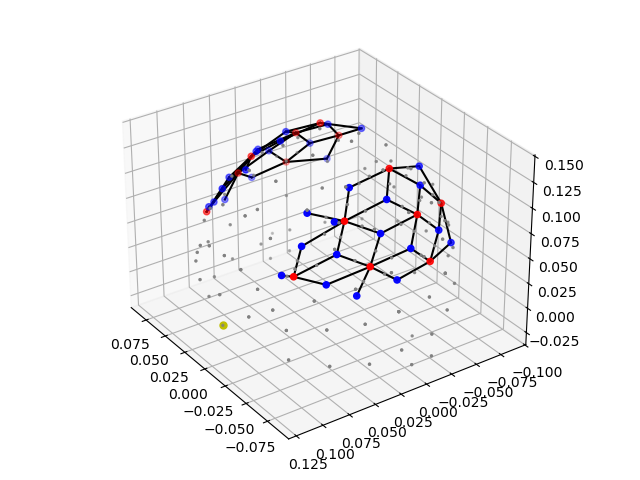

In [16]:
cedalion.plots.plot_montage3D(rec["amp"], rec.geo3d)

## Stim data

In [17]:
# load any events file to verify stim info for testing sampling rate
stim = cedalion.io.read_events_from_tsv(files[0].replace('nirs.snirf', 'events.tsv'))
if not np.all(stim["duration"] == stim["duration"][0]):
    raise RuntimeError("Non-uniform trial durations encountered.")

stim.head()

,onset,duration,trial_type,value,sample
0,61.040,2.0,motor,1,545
1,78.176,2.0,motor,1,698
2,99.232,2.0,motor,1,886
3,117.488,2.0,motor,1,1049
4,138.656,2.0,motor,1,1238


### Count number of trials of each type

In [18]:
print(stim.groupby("trial_type")[["onset"]].count())

            onset
trial_type       
motor          25


### Check differences between onsets (onsets are in seconds)

In [19]:
np.diff(np.sort(stim.onset.values)), np.min(np.diff(np.sort(stim.onset.values)))

(array([17.136, 21.056, 18.256, 21.168, 18.144, 15.232, 16.352, 15.008,
        23.072, 19.376, 17.024, 13.664, 14.672, 21.168, 14.224, 22.064,
        14.224, 17.136, 19.264, 18.144, 20.048, 22.176, 18.144, 19.264]),
 np.float64(13.664000000000044))

### Verify stim duration

In [ ]:
np.all(rec.stim['duration'] == rec.stim['duration'])

np.True_

# Save the parcel time series

In [ ]:
subject_to_rec = {}
skipped_subjects = []

PRE_PROCESSED_DIR = Path(f'/home/orabe/sparse_to_dense_fnirs/datasets/preprocessed/{DATASET_NAME}')
PRE_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

fluence_fname = f'{PRE_PROCESSED_DIR}/fluence_{DATASET_NAME}.h5'
sensitivity_fname = fluence_fname.replace(f'fluence_{DATASET_NAME}', f'sensitivity_{DATASET_NAME}')

# iterate over snirf files
for file in files:

    # ***********
    # [cell]
    # ### Channel-level Processing
    print('-'*10, 'processing : ', file)

    #-------------------------LOAD----------------------------------------------------
    try:
        rec = cedalion.io.read_snirf(file)[0]  # read snirf files
    except Exception as e:
        print(e)

    rec = match_landmark_labels(rec)
    
    #----------------------CONF-------------------------------------------------------
    ch_preproc = {
    'FLAG_OW'   : False,
    'FLAG_Plot' : True,
    'channel'   : 'S1D1',
    'pwindow'   : slice(4320,4500),
    'hp_filt'   : [0.008,0],            # fmin = 0.008, fmax = 0
    'sci_thresh' : 0.6,
    'psp_thresh' : 0.1,
    'window_len' : 5*units.s,           # 5 seconds
    'dark_sat_thresh' : [1e-3, 0.84],
    'perc_time_clean' : 0.5             # 50 %   

    }

    # pre-processing 
    rec['rep_amp'] = quality.repair_amp(rec['amp'], median_len=3, method='linear')  # Repair Amp
    rec['od_amp'], baseline= nirs.int2od(rec['rep_amp'],return_baseline=True)

    # motion correct [TDDR + WAVELET]
    rec["od_tddr"] = motion_correct.tddr(rec["od_amp"])
    rec["od_tddr_wavel"] = motion_correct.wavelet(rec["od_tddr"])

    #----------------------------------highpass filter----------------------------
    rec['od_hpfilt'] = rec['od_tddr_wavel'].cd.freq_filter(fmin=0.008,fmax=0,butter_order=4)
    #---------------------------------------------------------------------------------

    # clean amplitude data
    rec['amp_clean'] = cedalion.nirs.od2int(rec['od_hpfilt'], baseline)

    # get bad channel mask
    list_bad_ch = get_bad_ch_mask(rec["amp_clean"], ch_preproc) # this has custom paramerers!? 
    # list_bad_ch = []
    # print('the list of bad channels: ', len(list_bad_ch))
    if hasattr(rec['amp'], 'sizes') and 'channel' in rec['amp'].sizes:
        total_channels = rec['amp'].sizes['channel']
    elif hasattr(rec['amp'], 'channel'):
        total_channels = rec['amp'].channel.size
    else:
        total_channels = rec['amp'].shape[-1]

    if len(list_bad_ch) >= total_channels:
        print(f"Skipping {file} because all channels are marked as bad.")
        skipped_subjects.append(file)
        continue


    # channel variance
    od_var_vec = quality.measurement_variance(rec["od_hpfilt"], list_bad_channels=list_bad_ch, bad_rel_var=1e6,calc_covariance=False)

    #---------------------------------------------------------------------------------
    dpf = xr.DataArray(
        [6, 6],
        dims="wavelength",
        coords={"wavelength": rec["amp"].wavelength},
    )
    rec['conc'] = cedalion.nirs.od2conc(rec['od_hpfilt'], rec.geo3d, dpf, spectrum="prahl")

    # conc_pr vs conc 
    chromo_var = quality.measurement_variance(rec['conc'], list_bad_channels = list_bad_ch, bad_rel_var = 1e6, calc_covariance = False)
    rec['conc_pcr'], gb_comp_rem = physio.global_component_subtract(rec['conc'],ts_weights=1/chromo_var,k=0,spatial_dim='channel',spectral_dim='chromo')

    rec['od_pcr1'] = cedalion.nirs.conc2od(rec['conc_pcr'], rec.geo3d, dpf, spectrum="prahl")

    #---------------------------------------------------------------------------------
    ch_preproc['cmeas'] = get_cmeas(rec['od_hpfilt'], list_bad_ch, get_diag=True, bad_rel_var= 1e6, dw_bad_ch=True)
    ch_preproc['list_bad_ch'] = list_bad_ch


    # [cell]
    # Image recon
    SEG_DATADIR, mask_files, landmarks_file = get_icbm152_segmentation()
    PARCEL_DIR = cedalion.datasets.get_icbm152_parcel_file()

    head_icbm152 = TwoSurfaceHeadModel.from_surfaces(
        segmentation_dir=SEG_DATADIR,
        mask_files=mask_files,
        brain_surface_file=os.path.join(SEG_DATADIR, "mask_brain.obj"),
        scalp_surface_file=os.path.join(SEG_DATADIR, "mask_scalp.obj"),
        landmarks_ras_file=landmarks_file,
        parcel_file=PARCEL_DIR,
        brain_face_count=None,
        scalp_face_count=None,
        smoothing=0.0
    )
    #-----------------------------------CUSTOM---------------------------------------
    meas_list = rec._measurement_lists["amp"]

    # this is required for BU Data (Laura's)
    # -----------------------------------CUSTOM---------------------------------------
    if DATASET_NAME == "BS_Laura":
        # this is required for BU Data (Laura's)
        T = np.array([
            [-9.57882733e-01, -7.20806358e-03,  6.20193531e-03, 2.21208571e+02],
            [-2.02271710e-02,  6.03819925e-02,  9.94046165e-01, -2.03010603e+01],
            [-8.79481533e-03, -1.02761992e+00,  6.59199998e-02, 2.87749135e+02],
            [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]])
        
        ninja_aligned = rec.geo3d.points.apply_transform(T)
        geo3d_snapped_ijk = head_icbm152.align_and_snap_to_scalp(ninja_aligned)
    else:
        geo3d_snapped_ijk = head_icbm152.align_and_snap_to_scalp(rec.geo3d)
        
    # plt = pv.Plotter()
    # cedalion.plots.plot_surface(plt, head_icbm152.brain, color="w")
    # cedalion.plots.plot_surface(plt, head_icbm152.scalp, opacity=.1)
    # cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk) # loaded from file
    # plt.show()


    # [cell]
    fwm = cedalion.imagereco.forward_model.ForwardModel(head_icbm152, geo3d_snapped_ijk, meas_list)

    #---------------------- Compute Sensitivity (GPU!)----------------------------
    # fwm.compute_fluence_mcx(fluence_fname) # comment after
    # fwm.compute_sensitivity(fluence_fname, sensitivity_fname) # comment after
    #--------------------------------------------------------------------------------

    # Adot, Adot_stacked
    Adot = load_Adot(sensitivity_fname)
    Adot_stacked = fwm.compute_stacked_sensitivity(Adot)

    B = pseudo_inverse_stacked(Adot_stacked, alpha = 0.01, alpha_spatial = 0.001, Cmeas= ch_preproc['cmeas'])
    
    parcel_dOD, parcel_mask = fwm.parcel_sensitivity(
        Adot,
        ch_preproc['list_bad_ch'],
        dOD_thresh = 0.001,       
        minCh=1,
        dHbO=10,
        dHbR=-3
    )

    sensitive_parcels = parcel_mask.where(parcel_mask, drop=True)["parcel"].values.tolist()
    dropped_parcels = parcel_mask.where(~parcel_mask, drop=True)["parcel"].values.tolist()
    print(f"Number of sensitive parcels: {len(sensitive_parcels)}")
    print(f"Number of dropped parcels: {len(dropped_parcels)}")

    # this will plot sensitive parcels and save in SAVE
    # SAVE = f'/home/orabe/sparse_to_dense_fnirs/datasets/prepro_pipelines/{DATASET_NAME}'
    # plot_sens_parcels(removed_parcels=dropped_parcels, head=head_icbm152, subject=file.split('/')[-1].replace('.snirf', ''))
    # plot_sens_parcels(removed_parcels=[], head=head_icbm152, subject='allParcels_' + file.split('/')[-1].replace('.snirf', ''))

    # [cell]
    ### Final Time-Series Object - [Parcel, Chromo, Time]
    #------------------- HERE WE FEED od_pcr1 (global-physio-removed) -----------------
    signal_raw = od2parcel(rec['od_pcr1'], B)

    # signal
    signal_raw = signal_raw.pint.quantify({'time':'seconds'})
    signal_raw = signal_raw.transpose('parcel', "chromo", "time")

    # read-the stimulus
    stim = read_events_from_tsv(file.replace('nirs.snirf', 'events.tsv'))
    
    # # Expand trial duration for FreshMotor dataset
    if DATASET_NAME == "FreshMotor":
        # all trials are will be 3s long for consistency across fresh motor dataset. 
        stim['duration'] = 10.0 # rec will be inside standardize_trial_types() below
        
    stim, rec = standardize_trial_types(DATASET_NAME, file, stim, rec)
    label = {'right':1, 'left':2}

    # save the signal 
    data = {
        'signal_raw': signal_raw,
        'dropped_parcels': dropped_parcels,
        'sensitive_parcels': sensitive_parcels,
        'stim': stim,
        'label': label,
        'fs': fs,
    }

    # save as pickle
    path = PureWindowsPath(file)
    subject_dir = path.parts[-3]
    filename = path.stem

    if DATASET_NAME == "FreshMotor":
        subject_dir = path.parts[-4]
        session_label = path.parts[-3]
        task_fragment = next(
            (part for part in filename.split('_') if part.startswith('task-')),
            f"task-{DATASET_NAME.replace('_', '').upper()}",
        )
        run_fragment = session_label.replace('ses-', 'run-')
        filename = f'{subject_dir}_{task_fragment}_{run_fragment}_nirs'

    if subject_dir not in subject_to_rec:
        subject_to_rec[subject_dir] = []

    all_parcels_dir = PRE_PROCESSED_DIR / 'ts_all_parcels' / subject_dir
    all_parcels_dir.mkdir(parents=True, exist_ok=True)

    file_name_to_save = all_parcels_dir / f'{filename}_ts_all_parcels.pkl'

    with open(file_name_to_save, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

if skipped_subjects:
    print(f"Skipped {len(skipped_subjects)} file(s) because all channels were bad.")

print("Processing complete.")


---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-01/ses-left2s/nirs/sub-01_ses-left2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  25 / 68
Percentage:  36 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 146
Number of dropped parcels: 456
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-01/ses-left3s/nirs/sub-01_ses-left3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  26 / 68
Percentage:  38 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 145
Number of dropped parcels: 457
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-01/ses-right2s/nirs/sub-01_ses-right2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  22 / 68
Percentage:  32 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 146
Number of dropped parcels: 456
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-01/ses-right3s/nirs/sub-01_ses-right3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  21 / 68
Percentage:  30 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 150
Number of dropped parcels: 452
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-02/ses-left2s/nirs/sub-02_ses-left2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  30 / 68
Percentage:  44 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 141
Number of dropped parcels: 461
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-02/ses-left3s/nirs/sub-02_ses-left3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  35 / 68
Percentage:  51 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 131
Number of dropped parcels: 471
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-02/ses-right2s/nirs/sub-02_ses-right2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  36 / 68
Percentage:  52 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 129
Number of dropped parcels: 473
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-02/ses-right3s/nirs/sub-02_ses-right3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  40 / 68
Percentage:  58 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 115
Number of dropped parcels: 487
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-03/ses-left2s/nirs/sub-03_ses-left2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  19 / 68
Percentage:  27 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 162
Number of dropped parcels: 440
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-03/ses-left3s/nirs/sub-03_ses-left3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  22 / 68
Percentage:  32 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 162
Number of dropped parcels: 440
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-03/ses-right2s/nirs/sub-03_ses-right2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  20 / 68
Percentage:  29 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 162
Number of dropped parcels: 440
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-03/ses-right3s/nirs/sub-03_ses-right3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  22 / 68
Percentage:  32 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 162
Number of dropped parcels: 440
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-04/ses-left2s/nirs/sub-04_ses-left2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  15 / 68
Percentage:  22 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 167
Number of dropped parcels: 435
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-04/ses-left3s/nirs/sub-04_ses-left3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  17 / 68
Percentage:  25 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 162
Number of dropped parcels: 440
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-04/ses-right2s/nirs/sub-04_ses-right2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  13 / 68
Percentage:  19 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 162
Number of dropped parcels: 440
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-04/ses-right3s/nirs/sub-04_ses-right3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  14 / 68
Percentage:  20 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 164
Number of dropped parcels: 438
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-05/ses-left2s/nirs/sub-05_ses-left2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  24 / 68
Percentage:  35 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 149
Number of dropped parcels: 453
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-05/ses-left3s/nirs/sub-05_ses-left3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  22 / 68
Percentage:  32 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 150
Number of dropped parcels: 452
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-05/ses-right2s/nirs/sub-05_ses-right2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  18 / 68
Percentage:  26 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 154
Number of dropped parcels: 448
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-05/ses-right3s/nirs/sub-05_ses-right3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  21 / 68
Percentage:  30 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 150
Number of dropped parcels: 452
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-06/ses-left2s/nirs/sub-06_ses-left2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  27 / 68
Percentage:  39 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 140
Number of dropped parcels: 462
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-06/ses-left3s/nirs/sub-06_ses-left3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  29 / 68
Percentage:  42 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 139
Number of dropped parcels: 463
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-06/ses-right2s/nirs/sub-06_ses-right2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  68 / 68
Percentage:  100 %
Skipping /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-06/ses-right2s/nirs/sub-06_ses-right2s_task-FRESHMOTOR_nirs.snirf because all channels are marked as bad.
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-06/ses-right3s/nirs/sub-06_ses-right3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  68 / 68
Percentage:  100 %
Skipping /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-06/ses-right3s/nirs/sub-06_ses-right3s_task-FRESHMOTOR_nirs.snirf because all channels are marked as bad.
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-07/ses-left2s/nirs/sub-07_ses-left2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  32 / 68
Per

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 129
Number of dropped parcels: 473
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-07/ses-left3s/nirs/sub-07_ses-left3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  35 / 68
Percentage:  51 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 124
Number of dropped parcels: 478
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-07/ses-right2s/nirs/sub-07_ses-right2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  36 / 68
Percentage:  52 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 121
Number of dropped parcels: 481
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-07/ses-right3s/nirs/sub-07_ses-right3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  40 / 68
Percentage:  58 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 108
Number of dropped parcels: 494
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-08/ses-left2s/nirs/sub-08_ses-left2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  15 / 68
Percentage:  22 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 182
Number of dropped parcels: 420
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-08/ses-left3s/nirs/sub-08_ses-left3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  16 / 68
Percentage:  23 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 182
Number of dropped parcels: 420
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-08/ses-right2s/nirs/sub-08_ses-right2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  16 / 68
Percentage:  23 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 185
Number of dropped parcels: 417
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-08/ses-right3s/nirs/sub-08_ses-right3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  16 / 68
Percentage:  23 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 185
Number of dropped parcels: 417
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-09/ses-left2s/nirs/sub-09_ses-left2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  22 / 68
Percentage:  32 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 168
Number of dropped parcels: 434
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-09/ses-left3s/nirs/sub-09_ses-left3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  24 / 68
Percentage:  35 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 162
Number of dropped parcels: 440
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-09/ses-right2s/nirs/sub-09_ses-right2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  19 / 68
Percentage:  27 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 168
Number of dropped parcels: 434
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-09/ses-right3s/nirs/sub-09_ses-right3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  20 / 68
Percentage:  29 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 168
Number of dropped parcels: 434
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-10/ses-left2s/nirs/sub-10_ses-left2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  25 / 68
Percentage:  36 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 150
Number of dropped parcels: 452
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-10/ses-left3s/nirs/sub-10_ses-left3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  26 / 68
Percentage:  38 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 150
Number of dropped parcels: 452
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-10/ses-right2s/nirs/sub-10_ses-right2s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  26 / 68
Percentage:  38 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 150
Number of dropped parcels: 452
---------- processing :  /home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-10/ses-right3s/nirs/sub-10_ses-right3s_task-FRESHMOTOR_nirs.snirf
Flagged Channels :  26 / 68
Percentage:  38 %


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Number of sensitive parcels: 150
Number of dropped parcels: 452
Skipped 2 file(s) because all channels were bad.
Processing complete.


In [22]:
print(f"Skipped {len(skipped_subjects)} file(s) because all channels were bad.")
skipped_subjects

Skipped 2 file(s) because all channels were bad.


['/home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-06/ses-right2s/nirs/sub-06_ses-right2s_task-FRESHMOTOR_nirs.snirf',
 '/home/orabe/sparse_to_dense_fnirs/datasets/raw/FreshMotor/sub-06/ses-right3s/nirs/sub-06_ses-right3s_task-FRESHMOTOR_nirs.snirf']